In [12]:
import igraph as ig
import partition_igraph
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *
from itertools import combinations
from sklearn.metrics import adjusted_mutual_info_score as AMI


In [2]:
## DEV
path = '/data/ABCDoo/'
oNMI = '/work/home/fcthebe/Tools/oNMI/onmi' 

## MAC
#path = '../Datasets/ABCDoo/' 
#oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi' 


In [3]:
## calls the oNMI executable, format of inputs: list of lists (communities)
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L


# Dataset

College football dataset from:

[Ref]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799

with corresctions to the labels as described in: https://arxiv.org/pdf/1009.0638

The graph has 115 nodes, 613 edges and after the corrections, there are  12 communities corresponding to Football Conferences.

One of these communities is in fact a group of independent teamswhich we use as surrogate for outlier nodes.
    

In [8]:
## read graph and communities
cfg = ig.Graph.Read_Ncol('./football.edgelist',directed=False)
c = np.loadtxt('./football.community',dtype='uint16',usecols=(0))
cfg.vs['gt'] = [c[int(x['name'])] for x in cfg.vs]

## Apply corrections from: https://arxiv.org/pdf/1009.0638
## grouping the independent in cluster 5, keeping the othre clusters 

## more Independent teams
for v in [58,59,63,97]:
    cfg.vs[v]['gt'] = 5

## add to BigWest (not SunBelt)
for v in [28,90]:
    cfg.vs[v]['gt'] = 10
    
## add to WesternAthletic
cfg.vs[110]['gt'] = 11

print(cfg.vcount(), cfg.ecount(), max(cfg.vs['gt'])+1, cfg.is_simple())

115 613 12 True


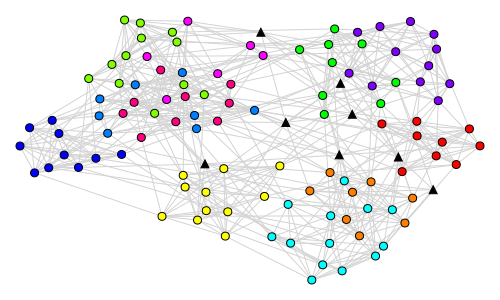

In [11]:
## plot the College Football Graph
## show communities in dfferent colors
## show known outliers as black triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['gt'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['gt']]
for v in cfg.vs:
    if v['gt']==5:
        v['shape']='triangle'
        v['anomaly']=1
        v['color']='black'
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


In [18]:
## run ECG and return one of the two "refuse to cluster" scores
ecg = cfg.community_ecg(final='leiden', refuse_score=True)
cfg.vs['ecg'] = ecg.membership

## pick one of the two here:
#cfg.vs['refuse_score'] = ecg.refuse_overall
cfg.vs['refuse_score'] = ecg.refuse_community


L = []
n = cfg.vcount()
for i in range(n-5):
    srt = list(np.argsort(cfg.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),
            sum([cfg.vs[i]['anomaly'] for i in list(np.argsort(cfg.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),0])
df = pd.DataFrame(L, columns=['refusals','AMI','outliers found'])


,refusals,AMI,outliers found
0,0,0.954708,0
1,1,0.963537,1
2,2,0.964600,2
3,3,0.966121,3
4,4,0.968497,4


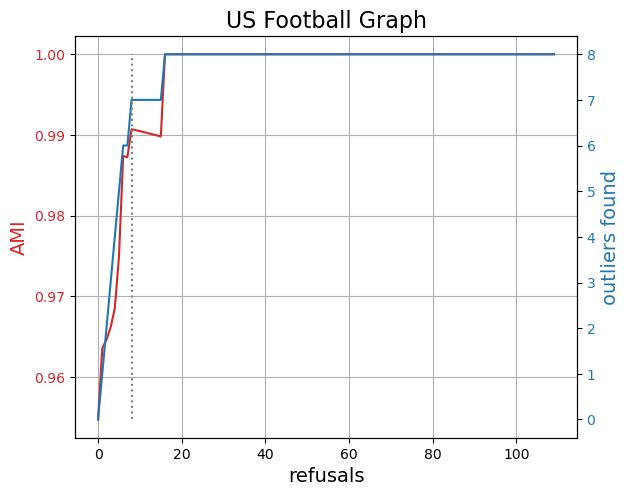

In [19]:
## plot the above values
## add vertical dashed line at 14, number of ground truth outliers

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('AMI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['AMI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('US Football Graph', fontsize=16)
plt.vlines(8,0,8,color='grey',linestyles='dotted')

plt.show()


In [37]:
## Independent teams (cluster == 5)
Indep = np.where(np.array(cfg.vs['gt'])==5)[0]

## 7 independent are found in the top-8; #42 takes a few more steps after which AMI = 1
print( np.argsort(cfg.vs['refuse_score'])[::-1][:18])
print([x in Indep for x in np.argsort(cfg.vs['refuse_score'])[::-1]][:18])


[ 36  58  59  63  82  80  11  97  24  69  23   9 104  90  67  42   5  50]
[True, True, True, True, True, True, False, True, False, False, False, False, False, False, False, True, False, False]


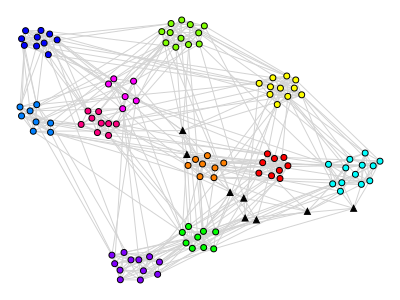

In [38]:
## use ECG weights to show the football graph
cfg.es['weight'] = ecg.W
cfg.vs['size'] = 6
cfg.vs['vertex_labels'] = cfg.vs['name']
ly = cfg.layout_fruchterman_reingold(weights='weight')
ig.plot(cfg, layout=ly, bbox=(0,0,400,300), edge_color='lightgray')


In [44]:
cfg.vs['leiden'] = cfg.community_leiden(objective_function='modularity').membership
GT = mems2comms( [[x] for x in cfg.vs['gt']])
EC = mems2comms([[x] for x in cfg.vs['ecg']])
LD = mems2comms([[x] for x in cfg.vs['leiden']])

print('ECG:',compute_oNMI(EC,GT),AMI(cfg.vs['gt'],cfg.vs['ecg']))
print('Leiden:',compute_oNMI(LD,GT),AMI(cfg.vs['gt'],cfg.vs['leiden']))


ECG: 0.928489 0.9547076259706208
Leiden: 0.809101 0.9115401963557498


In [105]:
## CAS score
cfg.vs['leiden'] = cfg.community_leiden(objective_function='modularity').membership


In [112]:
compute_oNMI(LD,GT)

0.928489

In [113]:
EC

[[0, 4, 9, 16, 23, 41, 93, 104],
 [1, 25, 33, 37, 45, 89, 103, 105, 109],
 [2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106],
 [3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107],
 [7, 8, 21, 22, 51, 68, 77, 78, 108, 111],
 [11, 24, 28, 50, 69, 90],
 [12, 14, 18, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 85, 99],
 [17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113],
 [19, 29, 30, 35, 55, 79, 80, 82, 94, 101],
 [44, 48, 57, 66, 75, 86, 91, 92, 112],
 [46, 49, 53, 67, 73, 83, 88, 110, 114],
 [58, 59, 63, 97]]

In [118]:
sys.path.append('../')
from CAS import *

A = cfg.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(cfg.vs['ecg']))
cfg.vs['nief'] = Beta.max(axis=1).toarray().flatten()


In [120]:
np.argsort(cfg.vs['nief'])

array([ 36,  58,  82,  80,  63,  97,  59,  69,  42,  24,  11,  28,  50,
        90, 104,   0, 112,  55,  35,  19,  91,  92,  66,  86,  44,  48,
         3,   5,  16,  23,   9,   4,   2,  15,   6,   7,  67,  88,  53,
         1,  31,  38,  61, 101,  40,  81,  84,  72,  74,  98,  75,  57,
        65,  70,  62,  87,  20,  76,  17,  27,  60,  32, 106, 100,  39,
        13,  64,  47,  93,  41,  77,  68,  22,  51,  21,   8,  78, 111,
        79,  30,  49,  83,  73,  46, 114, 110,  25,  37,  89, 109,  45,
        85,  99,  12,  26,  71,  14,  54,  10, 102, 107,  52, 113,  56,
        96,  95,  43,  34, 108, 105,  33, 103,  29,  18,  94])

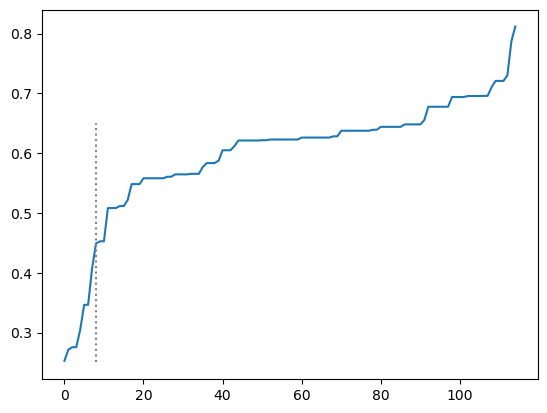

In [126]:
plt.plot(np.sort(cfg.vs['nief']))
plt.vlines(8,.25,.65, linestyles=':',color='grey')

In [127]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [148]:
ES = [c for c in EgoSplit(cfg, algo='leiden') if len(c)>2]


0.695855

In [154]:
comms_es = EgoSplit(cfg, algo='leiden')
ES = [list(x) for x in comms_es if len(x)>2]    


In [155]:

ctr = Counter([i for j in ES for i in j])
print(compute_oNMI( ES, GT ))

C = sparse.csc_matrix((cfg.vcount(),len(ES)))
C.indices = np.array([int(i) for j in ES for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ES:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()
## Beta
IEF, Beta, C, Pv, DegPart = CAS(cfg.get_adjacency_sparse(), M)


0.695855


In [156]:
cfg.vs['nief'] = Beta.max(axis=1).toarray().flatten()


In [157]:
np.argsort(cfg.vs['nief'])


array([ 82,  80,  58,  36,  63,  42,  24,  11,  59,  97,  69,  50,  90,
       104,  55, 112,   6,  16,   4,   9,  66,  48,  44,  86,  92,  91,
        53,  67, 101,  61,  31,   0,  17,  32,  47,  13,  62,  20,  60,
        64,  87,  19,  40,  84,  81,  28,  51,   8,  68,  22,  78,  25,
       109,  89,  41,  93,  75,  57,   2,  46,  73, 110,  49,   3,   5,
        85,   1,  23,  71,  14,  99,  26,  12,  56,  96, 107,  52,  10,
       102,  43,  34,  38, 108,  39, 106, 100,  70,  27,  76,  65, 103,
        29,  79,  35,  74,  72,  98,  21, 111,  15,  45,  37,   7, 114,
        83,  88,  54, 113,  95,  30,  77,  33,  18,  94, 105])

In [159]:
Beta.todense()

matrix([[0.05981512, 0.58754758, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.64314845, 0.00421425, 0.        , ..., 0.        , 0.00502991,
         0.        ],
        [0.        , 0.        , 0.1276509 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.0776509 , ..., 0.15676998, 0.52169657,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.05676998, 0.        ,
         0.        ],
        [0.        , 0.01179   , 0.        , ..., 0.04767907, 0.        ,
         0.71785555]])

In [175]:
np.where((Beta>=.25).sum(axis=1).flatten() >1)[1]

array([11])

In [177]:
## 2 and 4
Beta[11].todense()


matrix([[0.        , 0.12088091, 0.2776509 , 0.        , 0.44371941,
         0.        , 0.        , 0.        , 0.        , 0.05676998,
         0.        , 0.        ]])

In [178]:
ES

[['37', '62', '33', '45', '25', '103', '109', '0', '89', '80', '1', '105'],
 ['93', '90', '23', '9', '0', '4', '104', '16', '41'],
 ['5',
  '3',
  '102',
  '52',
  '107',
  '81',
  '97',
  '10',
  '98',
  '72',
  '74',
  '2',
  '84',
  '40'],
 ['82',
  '32',
  '13',
  '39',
  '100',
  '64',
  '14',
  '106',
  '2',
  '92',
  '15',
  '60',
  '47',
  '6'],
 ['28', '11', '90', '50', '4', '69', '24'],
 ['7',
  '46',
  '8',
  '51',
  '82',
  '108',
  '22',
  '21',
  '111',
  '73',
  '68',
  '77',
  '78'],
 ['36',
  '71',
  '34',
  '54',
  '43',
  '26',
  '12',
  '39',
  '61',
  '85',
  '18',
  '14',
  '19',
  '99',
  '31',
  '42',
  '38'],
 ['63',
  '113',
  '62',
  '87',
  '65',
  '96',
  '76',
  '70',
  '27',
  '17',
  '56',
  '20',
  '59',
  '69',
  '95'],
 ['55',
  '35',
  '34',
  '44',
  '82',
  '93',
  '30',
  '79',
  '109',
  '101',
  '80',
  '19',
  '94',
  '29'],
 ['36', '63', '58', '97', '59', '112'],
 ['44', '57', '112', '75', '48', '91', '86', '92', '66'],
 ['67', '53', '83', '11

In [183]:
4

4

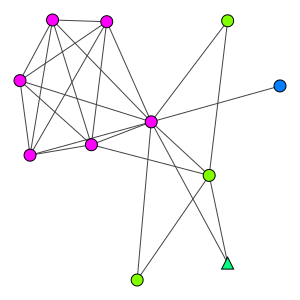

In [182]:
## egonet for 11

sg = cfg.subgraph(cfg.neighborhood(11))
ig.plot(sg, vertex_size=12, bbox=(300,300))



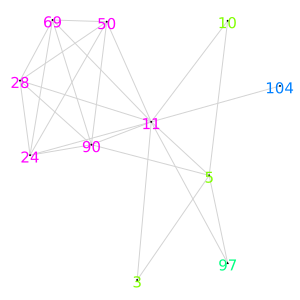

In [186]:
ig.plot(sg, bbox=(300,300), edge_color='lightgray', vertex_label_size=15, vertex_size=1, vertex_label=sg.vs['name'], vertex_label_color=sg.vs['color'])
